In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

!sudo apt-get install -y xvfb ffmpeg
!pip install 'xvfbwrapper==0.2.9'
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install gast
!pip install cffi
!pip install coloredlogs
!pip install cython
!pip install flask
!pip install gitpython
!pip install scikit-learn
!pip install scikit-image
!pip install tqdm
!pip install visdom
!pip install graphviz
!pip install pydot

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sn
import numpy as np
from datetime import datetime
import tensorflow as tf
import sklearn
import os
import abc
import base64
import imageio
import io
import IPython
import PIL.Image
import pyvirtualdisplay
import tensorflow_probability as tfp
import tempfile
import zipfile
import coloredlogs
import logging
from collections import deque
from pickle import Pickler, Unpickler
from random import shuffle
from tqdm import tqdm
import argparse
import shutil
import time
import random
import math
import sys
from tensorflow import keras

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Imitation Learning

In Imitation Learning tasks, the agent seeks the best
way to use a training set (input-output pair) demonstrated by an expert in order to learn a policy and
achieve an action as similar as possible as the expert’s one. Imitation is often needed to automate
actions when the agent is human and it is too expensive to run its actions in real-time. Apprenticeship
learning, on the contrary, executes pure greedy/exploitative policies and use all (state/action)
trajectories to learn a near-optimal policy using Reinforcement Learning approaches. It requires
difficult maneuvers and it is nearly impossible to recover from unobserved states. Imitation learning
can often deal with those unexplored states so it offers a more reliable framework for many tasks
such as self-driving cars. Types of Imitation Learning
* **Behaviour Cloning**: (Supervised Learning): Treats the experts state-action pairs (demonstrations) as independetally identically distributed (i.i.d.), and learns a mapping using supervised learning. If the state space is fully explored and our examples are i.i.d. it can work well, however in practice this is rarely the case (As in an MDP environment the action transitions to the next state conditioned on the previous state, breaking the i.i.d. requirement). It often performs poorly (outside of simple small well explored action spaces), as errors made in different states build up leading to failures.

## Inverse Reincforcement Learning (IRL)

Inverse reinforcement learning (IRL) starts with expert demonstrations of the desired behavior, infers a reward function that the expert likely followed and trains a policy to maximize that. There are two main approaches depending if we use a **model** (given or learnt) or use a **model-free** approach:
* **model-based**: Reward function is linear, and we need to solve the full RL problem upon each iteration
* **model-free**: Reward function is complex and is modelled with a neural network. Each iteration we only solve a single step of the RL problem.

In practice we recommend using the *Generative adversarial imitation learning*, a stable implementation of this can be found in [stable-baselines](https://github.com/hill-a/stable-baselines), and can be used as:

```python
import gym

from stable_baselines import GAIL, SAC
from stable_baselines.gail import ExpertDataset, generate_expert_traj

# Generate expert trajectories (train expert)
model = SAC('MlpPolicy', 'Pendulum-v0', verbose=1)
generate_expert_traj(model, 'expert_pendulum', n_timesteps=100, n_episodes=10)

# Load the expert dataset
dataset = ExpertDataset(expert_path='expert_pendulum.npz', traj_limitation=10, verbose=1)

model = GAIL('MlpPolicy', 'Pendulum-v0', dataset, verbose=1)
# Note: in practice, you need to train for 1M steps to have a working policy
model.learn(total_timesteps=1000)
model.save("gail_pendulum")

del model # remove to demonstrate saving and loading

model = GAIL.load("gail_pendulum")

env = gym.make('Pendulum-v0')
obs = env.reset()
while True:
  action, _states = model.predict(obs)
  obs, rewards, dones, info = env.step(action)
  env.render()
```


# Model based Reinforcement Learning

Let us revisit our taxonomy of reinforcement learning learning algorithms, this time looking at **model-based RL** algrotihms.



## What to Learn in Model-Based RL

Unlike *model-free RL*, there aren’t a small number of easy-to-define clusters of methods for model-based RL instaead there are many orthogonal ways of using models. Let's look at a few examples, however this list is far from exhaustive. In each case, the model may either be given or learned.

First a bit of background on **Pure Planning**. The most basic approach never explicitly represents the policy, and instead, uses pure planning techniques like *model-predictive control* (MPC) to select actions. In MPC, each time the agent observes the environment, it computes a plan which is optimal with respect to the model, where the plan describes all actions to take over some fixed window of time after the present. (Future rewards beyond the horizon may be considered by the planning algorithm through the use of a learned value function.) The agent then executes the first action of the plan, and immediately discards the rest of it. It computes a new plan each time it prepares to interact with the environment, to avoid using an action from a plan with a shorter-than-desired planning horizon. The [MBMF](https://sites.google.com/view/mbmf) work explores MPC with learned environment models on some standard benchmark tasks for deep RL.

* **Expert Iteration**. A straightforward follow-on to pure planning involves using and learning an explicit representation of the policy, $\pi_{\theta}(a|s)$. The agent uses a planning algorithm (like Monte Carlo Tree Search) in the model, generating candidate actions for the plan by sampling from its current policy. The planning algorithm produces an action which is better than what the policy alone would have produced, hence it is an "*expert*” relative to the policy. The policy is afterwards updated to produce an action more like the planning algorithm’s output.
    * The [ExIt](https://arxiv.org/abs/1705.08439) algorithm uses this approach to train deep neural networks to play Hex.
    * [AlphaZero](https://arxiv.org/abs/1712.01815) we provide the model of the world.
    * [MuZero](https://arxiv.org/abs/1911.08265) we learn the model of the world.

* **Data Augmentation for Model-Free Methods**. Use a model-free RL algorithm to train a policy or Q-function, however either 1) augment real experiences with fictitious ones in updating the agent, or 2) use only fictitous experience for updating the agent.
    * See [MBVE](https://arxiv.org/abs/1803.00101) for an example of augmenting real experiences with fictitious ones.
    * See [World Models](https://worldmodels.github.io/) for an example of using purely fictitious experience to train the agent, which they call “training in the dream.”

* **Embedding Planning Loops into Policies**. Another approach embeds the planning procedure directly into a policy as a subroutine—so that complete plans become side information for the policy—while training the output of the policy with any standard model-free algorithm. The key concept is that in this framework, the policy can learn to choose how and when to use the plans. This makes model bias less of a problem, because if the model is bad for planning in some states, the policy can simply learn to ignore it.
    * See [I2A](https://arxiv.org/abs/1707.06203) for an example of agents being endowed with this style of imagination.
    
    
# AlphaZero

AlphaZero starts from random play, given no domain knowledge (unlike AlphaGo) except the **game rules**.
The original [paper](https://arxiv.org/abs/1712.01815) mentions that AlphaZero was able to achieve achieved within 24 hours a superhuman level of play in the games of chess and shogi (Japanese chess) as well as Go, and convincingly defeated a world-champion program in each case.

AlphaZero uses a deep neural network $(p,v)=f_\theta(s)$ with parameters $\theta$, which takes the board position $s$ as an input and outputs a vector of move probabilities $p$ with components $p_a=Pr(a|s)$ for each action $a$, and a scalar value $v$ estiamting the expected outcome $z$ from position $s$, $v\approx E[z|s]$. Here it learns these move probabilities and value estimates entirely from self-play, which are then used guide its search.

It uses Monte-Carlo tree search (MCTS) algorithm, where each search consists of a series of simulated games of self-play that traverse a tree from root $s_{root}$ to leaf. Where each simulation selects each state $s$ with an action $a$ with the lowest visit count, highest move probability and highest value (averaged over the leaf states of simulations that selected $a$ from $s$) according to the current neural network $f_\theta$. This search returns a vector $\pi$ vector representing a probability distribution over moves, either proportionally or greedily with respect to the visit counts at the root state. The parameters $\theta$ of the $f_\theta$ are trained by self-play. Games are played by selecting moves for both players by MCTS, $a_t ~ \pi_t$. At the end of the game, the terminal position $s_T$ is scored according to the rules of the game to compute the game outcome $z$: $−1$ for a loss, $0$ for a draw or $+1$ for a win. $f_\theta$ is trained with the loss function to minimise the error between the predicted outcome $v_t$ and the game outcome $z$, and to maximise the similarity of the policy vector $p_t$
to the search probabilities $\pi_t$. Specifically the loss function $l$ sums over mean-squared error and cross-entropy losses respectively: 

$$ (p, v) = f_\theta(s) $$

$$ l = (z − v)^2 - \pi^T log(p) + c\|\theta\|^2 $$

where $c$ is a parameter controlling the level of $L2$ weight regularisation. Here the updated parameters are used in subsequent games of self-play.

This optimises the expected outcome, taking account of draws or potentially other outcomes.

The deep neural network design, that performs best empirically was found to be residual networks and shared the parameters for the value and policy networks.

## Monte Carlo tree search

The focus of MCTS is on the analysis of the most promising moves, expanding the search tree based on random sampling of the search space.
The application of Monte Carlo tree search in games is based on many *playouts,* also called *roll-outs*. In each playout, the game is played out to the very end by selecting moves at random. The final game result of each playout is then used to weight the nodes in the game tree so that better nodes are more likely to be chosen in future playouts.

The most basic way to use playouts is to apply the same number of playouts after each legal move of the current player, then choose the move which led to the most victories. The efficiency of this method—called *Pure Monte Carlo Game Search*—often increases with time as more playouts are assigned to the moves that have frequently resulted in the current player's victory according to previous playouts. Each round of Monte Carlo tree search consists of four steps:
* **Selection**: Start from root $R$ and select successive child nodes until a leaf node $L$ is reached. The root is the current game state and a leaf is any node from which no simulation (playout) has yet been initiated. The section below says more about a way of biasing choice of child nodes that lets the game tree expand towards the most promising moves, which is the essence of Monte Carlo tree search.
* **Expansion**: Unless $L$ ends the game decisively (e.g. win/loss/draw) for either player, create one (or more) child nodes and choose node $C$ from one of them. Child nodes are any valid moves from the game position defined by $L$.
* **Simulation**: Complete one random playout from node $C$. This step is sometimes also called playout or rollout. A playout may be as simple as choosing uniform random moves until the game is decided (for example in chess, the game is won, lost, or drawn).
* **Backpropagation**: Use the result of the playout to update information in the nodes on the path from $C$ to $R$.

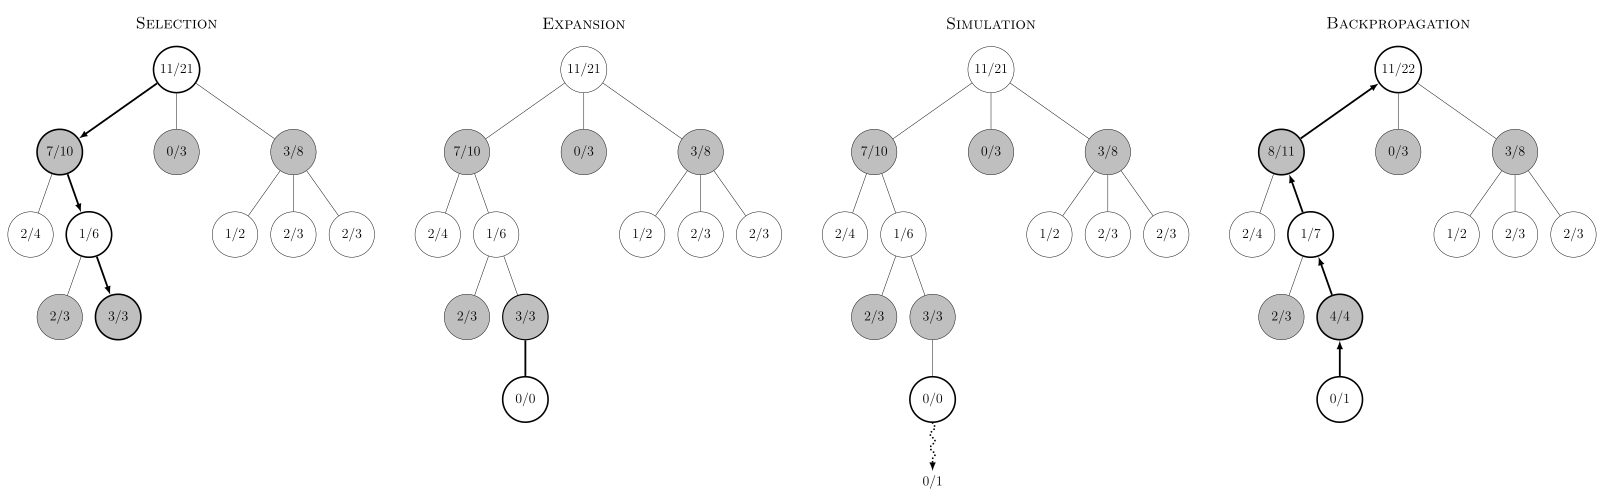

> Steps of Monte Carlo Tree Search

This graph shows the steps involved in one decision, with each node showing the ratio of wins to total playouts from that point in the game tree for the player that the node represents. In the Selection diagram, black is about to move. The root node shows there are 11 wins out of 21 playouts for white from this position so far. It complements the total of 10/21 black wins shown along the three black nodes under it, each of which represents a possible black move.

If white loses the simulation, all nodes along the selection incremented their simulation count (the denominator), but among them only the black nodes were credited with wins (the numerator). If instead white wins, all nodes along the selection would still increment their simulation count, but among them only the white nodes would be credited with wins. In games where draws are possible, a draw causes the numerator for both black and white to be incremented by 0.5 and the denominator by 1. This ensures that during selection, each player's choices expand towards the most promising moves for that player, which mirrors the goal of each player to maximize the value of their move.

Rounds of search are repeated as long as the time allotted to a move remains. Then the move with the most simulations made (i.e. the highest denominator) is chosen as the final answer.

# AlphaZero in TensorFlow

Lets implement AlphaZero in TensorFlow from scratch. Lets train to play TicTacToe.

In [2]:
log = logging.getLogger(__name__)

EPS = 1e-8

class Arena():
    """
    An Arena class where any 2 agents can be pit against each other.
    """

    def __init__(self, player1, player2, game, display=None):
        """
        Input:
            player 1,2: two functions that takes board as input, return action
            game: Game object
            display: a function that takes board as input and prints it. Is necessary for verbose mode.
        """
        self.player1 = player1
        self.player2 = player2
        self.game = game
        self.display = display

    def playGame(self, verbose=False):
        """
        Executes one episode of a game.

        Returns:
            either
                winner: player who won the game (1 if player1, -1 if player2)
            or
                draw result returned from the game that is neither 1, -1, nor 0.
        """
        players = [self.player2, None, self.player1]
        curPlayer = 1
        board = self.game.getInitBoard()
        it = 0
        while self.game.getGameEnded(board, curPlayer) == 0:
            it += 1
            if verbose:
                assert self.display
                print("Turn ", str(it), "Player ", str(curPlayer))
                self.display(board)
            action = players[curPlayer + 1](self.game.getCanonicalForm(board, curPlayer))

            valids = self.game.getValidMoves(self.game.getCanonicalForm(board, curPlayer), 1)

            if valids[action] == 0:
                log.error(f'Action {action} is not valid!')
                log.debug(f'valids = {valids}')
                assert valids[action] > 0
            board, curPlayer = self.game.getNextState(board, curPlayer, action)
        if verbose:
            assert self.display
            print("Game over: Turn ", str(it), "Result ", str(self.game.getGameEnded(board, 1)))
            self.display(board)
        return curPlayer * self.game.getGameEnded(board, curPlayer)

    def playGames(self, num, verbose=False):
        """
        Plays num games in which player1 starts num/2 games and player2 starts
        num/2 games.

        Returns:
            oneWon: games won by player1
            twoWon: games won by player2
            draws:  games won by nobody
        """

        num = int(num / 2)
        oneWon = 0
        twoWon = 0
        draws = 0
        for _ in tqdm(range(num), desc="Arena.playGames (1)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == 1:
                oneWon += 1
            elif gameResult == -1:
                twoWon += 1
            else:
                draws += 1

        self.player1, self.player2 = self.player2, self.player1

        for _ in tqdm(range(num), desc="Arena.playGames (2)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == -1:
                oneWon += 1
            elif gameResult == 1:
                twoWon += 1
            else:
                draws += 1

        return oneWon, twoWon, draws


class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}  # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}  # stores #times edge s,a was visited
        self.Ns = {}  # stores #times board s was visited
        self.Ps = {}  # stores initial policy (returned by neural net)

        self.Es = {}  # stores game.getGameEnded ended for board s
        self.Vs = {}  # stores game.getValidMoves for board s

    def getActionProb(self, canonicalBoard, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.

        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(canonicalBoard)

        s = self.game.stringRepresentation(canonicalBoard)
        counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

        if temp == 0:
            bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
            bestA = np.random.choice(bestAs)
            probs = [0] * len(counts)
            probs[bestA] = 1
            return probs

        counts = [x ** (1. / temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x / counts_sum for x in counts]
        return probs

    def search(self, canonicalBoard):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.

        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.

        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.

        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(canonicalBoard)

        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
        if self.Es[s] != 0:
            # terminal node
            return -self.Es[s]

        if s not in self.Ps:
            # leaf node
            self.Ps[s], v = self.nnet.predict(canonicalBoard)
            valids = self.game.getValidMoves(canonicalBoard, 1)
            self.Ps[s] = self.Ps[s] * valids  # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s  # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable

                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                log.error("All valid moves were masked, doing a workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return -v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s, a) in self.Qsa:
                    u = self.Qsa[(s, a)] + self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (
                            1 + self.Nsa[(s, a)])
                else:
                    u = self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s] + EPS)  # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
        next_s = self.game.getCanonicalForm(next_s, next_player)

        v = self.search(next_s)

        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            self.Nsa[(s, a)] += 1

        else:
            self.Qsa[(s, a)] = v
            self.Nsa[(s, a)] = 1

        self.Ns[s] += 1
        return -v

    

class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.nnet, self.args)
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False  # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.

        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.

        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getInitBoard()
        self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            canonicalBoard = self.game.getCanonicalForm(board, self.curPlayer)
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(canonicalBoard, temp=temp)
            sym = self.game.getSymmetries(canonicalBoard, pi)
            for b, p in sym:
                trainExamples.append([b, self.curPlayer, p, None])

            action = np.random.choice(len(pi), p=pi)
            board, self.curPlayer = self.game.getNextState(board, self.curPlayer, action)

            r = self.game.getGameEnded(board, self.curPlayer)

            if r != 0:
                return [(x[0], x[2], r * ((-1) ** (x[1] != self.curPlayer))) for x in trainExamples]

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """

        for i in range(1, self.args.numIters + 1):
            # bookkeeping
            log.info(f'Starting Iter #{i} ...')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i > 1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for _ in tqdm(range(self.args.numEps), desc="Self Play"):
                    self.mcts = MCTS(self.game, self.nnet, self.args)  # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                # save the iteration examples to the history 
                self.trainExamplesHistory.append(iterationTrainExamples)

            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                log.warning(
                    f"Removing the oldest entry in trainExamples. len(trainExamplesHistory) = {len(self.trainExamplesHistory)}")
                self.trainExamplesHistory.pop(0)
            # backup history to a file
            # NB! the examples were collected using the model from the previous iteration, so (i-1)  
            self.saveTrainExamples(i - 1)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)

            # training new network, keeping a copy of the old one
            self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            pmcts = MCTS(self.game, self.pnet, self.args)

            self.nnet.train(trainExamples)
            nmcts = MCTS(self.game, self.nnet, self.args)

            log.info('PITTING AGAINST PREVIOUS VERSION')
            arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
                          lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
            pwins, nwins, draws = arena.playGames(self.args.arenaCompare)

            log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
            if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
                log.info('REJECTING NEW MODEL')
                self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            else:
                log.info('ACCEPTING NEW MODEL')
                self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
                self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')

    def getCheckpointFile(self, iteration):
        return 'checkpoint_' + str(iteration) + '.pth.tar'

    def saveTrainExamples(self, iteration):
        folder = self.args.checkpoint
        if not os.path.exists(folder):
            os.makedirs(folder)
        filename = os.path.join(folder, self.getCheckpointFile(iteration) + ".examples")
        with open(filename, "wb+") as f:
            Pickler(f).dump(self.trainExamplesHistory)
        f.closed

    def loadTrainExamples(self):
        modelFile = os.path.join(self.args.load_folder_file[0], self.args.load_folder_file[1])
        examplesFile = modelFile + ".examples"
        if not os.path.isfile(examplesFile):
            log.warning(f'File "{examplesFile}" with trainExamples not found!')
            r = input("Continue? [y|n]")
            if r != "y":
                sys.exit()
        else:
            log.info("File with trainExamples found. Loading it...")
            with open(examplesFile, "rb") as f:
                self.trainExamplesHistory = Unpickler(f).load()
            log.info('Loading done!')

            # examples based on the model were already collected (loaded)
            self.skipFirstSelfPlay = True

Lets create a base game class, for which we will implement with our specific game, here Tic Tac Toe

In [3]:
class Game():
    """
    This class specifies the base Game class. To define your own game, subclass
    this class and implement the functions below. This works when the game is
    two-player, adversarial and turn-based.

    Use 1 for player1 and -1 for player2.
    """
    def __init__(self):
        pass

    def getInitBoard(self):
        """
        Returns:
            startBoard: a representation of the board (ideally this is the form
                        that will be the input to your neural network)
        """
        pass

    def getBoardSize(self):
        """
        Returns:
            (x,y): a tuple of board dimensions
        """
        pass

    def getActionSize(self):
        """
        Returns:
            actionSize: number of all possible actions
        """
        pass

    def getNextState(self, board, player, action):
        """
        Input:
            board: current board
            player: current player (1 or -1)
            action: action taken by current player

        Returns:
            nextBoard: board after applying action
            nextPlayer: player who plays in the next turn (should be -player)
        """
        pass

    def getValidMoves(self, board, player):
        """
        Input:
            board: current board
            player: current player

        Returns:
            validMoves: a binary vector of length self.getActionSize(), 1 for
                        moves that are valid from the current board and player,
                        0 for invalid moves
        """
        pass

    def getGameEnded(self, board, player):
        """
        Input:
            board: current board
            player: current player (1 or -1)

        Returns:
            r: 0 if game has not ended. 1 if player won, -1 if player lost,
               small non-zero value for draw.
               
        """
        pass

    def getCanonicalForm(self, board, player):
        """
        Input:
            board: current board
            player: current player (1 or -1)

        Returns:
            canonicalBoard: returns canonical form of board. The canonical form
                            should be independent of player. For e.g. in chess,
                            the canonical form can be chosen to be from the pov
                            of white. When the player is white, we can return
                            board as is. When the player is black, we can invert
                            the colors and return the board.
        """
        pass

    def getSymmetries(self, board, pi):
        """
        Input:
            board: current board
            pi: policy vector of size self.getActionSize()

        Returns:
            symmForms: a list of [(board,pi)] where each tuple is a symmetrical
                       form of the board and the corresponding pi vector. This
                       is used when training the neural network from examples.
        """
        pass

    def stringRepresentation(self, board):
        """
        Input:
            board: current board

        Returns:
            boardString: a quick conversion of board to a string format.
                         Required by MCTS for hashing.
        """
        pass


In [4]:
'''
Board class for the game of TicTacToe.
Default board size is 3x3.
Board data:
  1=white(O), -1=black(X), 0=empty
  first dim is column , 2nd is row:
     pieces[0][0] is the top left square,
     pieces[2][0] is the bottom left square,
Squares are stored and manipulated as (x,y) tuples.
'''

class Board():

    # list of all 8 directions on the board, as (x,y) offsets
    __directions = [(1,1),(1,0),(1,-1),(0,-1),(-1,-1),(-1,0),(-1,1),(0,1)]

    def __init__(self, n=3):
        "Set up initial board configuration."

        self.n = n
        # Create the empty board array.
        self.pieces = [None]*self.n
        for i in range(self.n):
            self.pieces[i] = [0]*self.n

    # add [][] indexer syntax to the Board
    def __getitem__(self, index): 
        return self.pieces[index]

    def get_legal_moves(self, color):
        """Returns all the legal moves for the given color.
        (1 for white, -1 for black)
        @param color not used and came from previous version.        
        """
        moves = set()  # stores the legal moves.

        # Get all the empty squares (color==0)
        for y in range(self.n):
            for x in range(self.n):
                if self[x][y]==0:
                    newmove = (x,y)
                    moves.add(newmove)
        return list(moves)

    def has_legal_moves(self):
        for y in range(self.n):
            for x in range(self.n):
                if self[x][y]==0:
                    return True
        return False
    
    def is_win(self, color):
        """Check whether the given player has collected a triplet in any direction; 
        @param color (1=white,-1=black)
        """
        win = self.n
        # check y-strips
        for y in range(self.n):
            count = 0
            for x in range(self.n):
                if self[x][y]==color:
                    count += 1
            if count==win:
                return True
        # check x-strips
        for x in range(self.n):
            count = 0
            for y in range(self.n):
                if self[x][y]==color:
                    count += 1
            if count==win:
                return True
        # check two diagonal strips
        count = 0
        for d in range(self.n):
            if self[d][d]==color:
                count += 1
        if count==win:
            return True
        count = 0
        for d in range(self.n):
            if self[d][self.n-d-1]==color:
                count += 1
        if count==win:
            return True
        
        return False

    def execute_move(self, move, color):
        """Perform the given move on the board; 
        color gives the color pf the piece to play (1=white,-1=black)
        """

        (x,y) = move

        # Add the piece to the empty square.
        assert self[x][y] == 0
        self[x][y] = color


class TicTacToeGame(Game):
    def __init__(self, n=3):
        self.n = n

    def getInitBoard(self):
        # return initial board (numpy board)
        b = Board(self.n)
        return np.array(b.pieces)

    def getBoardSize(self):
        # (a,b) tuple
        return (self.n, self.n)

    def getActionSize(self):
        # return number of actions
        return self.n*self.n + 1

    def getNextState(self, board, player, action):
        # if player takes action on board, return next (board,player)
        # action must be a valid move
        if action == self.n*self.n:
            return (board, -player)
        b = Board(self.n)
        b.pieces = np.copy(board)
        move = (int(action/self.n), action%self.n)
        b.execute_move(move, player)
        return (b.pieces, -player)

    def getValidMoves(self, board, player):
        # return a fixed size binary vector
        valids = [0]*self.getActionSize()
        b = Board(self.n)
        b.pieces = np.copy(board)
        legalMoves =  b.get_legal_moves(player)
        if len(legalMoves)==0:
            valids[-1]=1
            return np.array(valids)
        for x, y in legalMoves:
            valids[self.n*x+y]=1
        return np.array(valids)

    def getGameEnded(self, board, player):
        # return 0 if not ended, 1 if player 1 won, -1 if player 1 lost
        # player = 1
        b = Board(self.n)
        b.pieces = np.copy(board)

        if b.is_win(player):
            return 1
        if b.is_win(-player):
            return -1
        if b.has_legal_moves():
            return 0
        # draw has a very little value 
        return 1e-4

    def getCanonicalForm(self, board, player):
        # return state if player==1, else return -state if player==-1
        return player*board

    def getSymmetries(self, board, pi):
        # mirror, rotational
        assert(len(pi) == self.n**2+1)  # 1 for pass
        pi_board = np.reshape(pi[:-1], (self.n, self.n))
        l = []

        for i in range(1, 5):
            for j in [True, False]:
                newB = np.rot90(board, i)
                newPi = np.rot90(pi_board, i)
                if j:
                    newB = np.fliplr(newB)
                    newPi = np.fliplr(newPi)
                l += [(newB, list(newPi.ravel()) + [pi[-1]])]
        return l

    def stringRepresentation(self, board):
        # 8x8 numpy array (canonical board)
        return board.tostring()

    @staticmethod
    def display(board):
        n = board.shape[0]

        print("   ", end="")
        for y in range(n):
            print (y,"", end="")
        print("")
        print("  ", end="")
        for _ in range(n):
            print ("-", end="-")
        print("--")
        for y in range(n):
            print(y, "|",end="")    # print the row #
            for x in range(n):
                piece = board[y][x]    # get the piece to print
                if piece == -1: print("X ",end="")
                elif piece == 1: print("O ",end="")
                else:
                    if x==n:
                        print("-",end="")
                    else:
                        print("- ",end="")
            print("|")

        print("  ", end="")
        for _ in range(n):
            print ("-", end="-")
        print("--")



In [5]:
class AverageMeter(object):
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def __repr__(self):
        return f'{self.avg:.2e}'

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class dotdict(dict):
    def __getattr__(self, name):
        return self[name]


Lets define our $(p,v)=f_\theta(s)$ Neural Network model in Keras

In [6]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

class TicTacToeNNet():
    def __init__(self, game, args):
        # game params
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()
        self.args = args

        # Neural Net
        self.input_boards = Input(shape=(self.board_x, self.board_y))    # s: batch_size x board_x x board_y

        x_image = Reshape((self.board_x, self.board_y, 1))(self.input_boards)                # batch_size  x board_x x board_y x 1
        h_conv1 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(x_image)))         # batch_size  x board_x x board_y x num_channels
        h_conv2 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(h_conv1)))         # batch_size  x board_x x board_y x num_channels
        h_conv3 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(h_conv2)))        # batch_size  x (board_x) x (board_y) x num_channels
        h_conv4 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='valid')(h_conv3)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
        h_conv4_flat = Flatten()(h_conv4)       
        s_fc1 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024)(h_conv4_flat))))  # batch_size x 1024
        s_fc2 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(512)(s_fc1))))          # batch_size x 1024
        self.pi = Dense(self.action_size, activation='softmax', name='pi')(s_fc2)   # batch_size x self.action_size
        self.v = Dense(1, activation='tanh', name='v')(s_fc2)                    # batch_size x 1

        self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
        self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))


We can specify a base NueralNet class as well that we will have to implement with our own game specific case

In [7]:
class NeuralNet():
    """
    This class specifies the base NeuralNet class. To define your own neural
    network, subclass this class and implement the functions below. The neural
    network does not consider the current player, and instead only deals with
    the canonical form of the board.
    """

    def __init__(self, game):
        pass

    def train(self, examples):
        """
        This function trains the neural network with examples obtained from
        self-play.

        Input:
            examples: a list of training examples, where each example is of form
                      (board, pi, v). pi is the MCTS informed policy vector for
                      the given board, and v is its value. The examples has
                      board in its canonical form.
        """
        pass

    def predict(self, board):
        """
        Input:
            board: current board in its canonical form.

        Returns:
            pi: a policy vector for the current board- a numpy array of length
                game.getActionSize
            v: a float in [-1,1] that gives the value of the current board
        """
        pass

    def save_checkpoint(self, folder, filename):
        """
        Saves the current neural network (with its parameters) in
        folder/filename
        """
        pass

    def load_checkpoint(self, folder, filename):
        """
        Loads parameters of the neural network from folder/filename
        """
        pass


In [8]:
NNargs = dotdict({
    'lr': 0.001,
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 64,
    'cuda': True,
    'num_channels': 512,
})


class NNetWrapper(NeuralNet):
    def __init__(self, game):
        self.nnet = TicTacToeNNet(game, NNargs)
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        input_boards, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray(input_boards)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        self.nnet.model.fit(x=input_boards, y=[
                            target_pis, target_vs], batch_size=NNargs.batch_size, epochs=NNargs.epochs)

    def predict(self, board):
        """
        board: np array with board
        """
        # timing
        start = time.time()

        # preparing input
        board = board[np.newaxis, :, :]

        # run
        pi, v = self.nnet.model.predict(board)

        #print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return pi[0], v[0]

    def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        filepath = os.path.join(folder, filename)
        if not os.path.exists(folder):
            print(
                "Checkpoint Directory does not exist! Making directory {}".format(folder))
            os.mkdir(folder)
        else:
            print("Checkpoint Directory exists! ")
        self.nnet.model.save_weights(filepath)

    def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
        filepath = os.path.join(folder, filename)
        if not os.path.exists(filepath):
            raise("No model in path '{}'".format(filepath))
        self.nnet.model.load_weights(filepath)



In [9]:
coloredlogs.install(level='INFO')  # Change this to DEBUG to see more info.

args = dotdict({
    'numIters': 5,
    # Number of complete self-play games to simulate during a new iteration.
    'numEps': 20,
    'tempThreshold': 15,
    # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'updateThreshold': 0.6,
    # Number of game examples to train the neural networks.
    'maxlenOfQueue': 200000,
    'numMCTSSims': 25,          # Number of games moves for MCTS to simulate.
    # Number of games to play during arena play to determine if new net will be accepted.
    'arenaCompare': 40,
    'cpuct': 1,
    'checkpoint': './temp/',
    'load_model': False,
    'load_folder_file': ('./tmp/models', 'best.pth.tar'),
    'numItersForTrainExamplesHistory': 20,
})



log.info('Loading %s...', TicTacToeGame.__name__)
g = TicTacToeGame()

log.info('Loading %s...', NNetWrapper.__name__)
nnet = NNetWrapper(g)

if args.load_model:
    log.info('Loading checkpoint "%s/%s"...', args.load_folder_file)
    nnet.load_checkpoint(
        args.load_folder_file[0], args.load_folder_file[1])
else:
    log.warning('Not loading a checkpoint!')

log.info('Loading the Coach...')
c = Coach(g, nnet, args)

if args.load_model:
    log.info("Loading 'trainExamples' from file...")
    c.loadTrainExamples()

2020-05-29 02:15:53 ip-172-31-41-236 __main__[2930] INFO Loading TicTacToeGame...
2020-05-29 02:15:53 ip-172-31-41-236 __main__[2930] INFO Loading NNetWrapper...
2020-05-29 02:15:55 ip-172-31-41-236 __main__[2930] WARNING Not loading a checkpoint!
2020-05-29 02:15:55 ip-172-31-41-236 __main__[2930] INFO Loading the Coach...


Lets plot our model of $(p,v)=f_\theta(s)$

In [10]:
nnet.nnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 3)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 3, 3, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 3, 512)    5120        reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 3, 3, 512)    2048        conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
log.info('Starting the learning process 🎉')
c.learn()

2020-05-29 02:15:55 ip-172-31-41-236 __main__[2930] INFO Starting the learning process 🎉
2020-05-29 02:15:55 ip-172-31-41-236 __main__[2930] INFO Starting Iter #1 ...
Self Play: 100%|██████████| 20/20 [01:02<00:00,  3.12s/it]


Checkpoint Directory exists! 
Epoch 1/10
17/17 [==============================] - 0s 13ms/step - loss: 3.6462 - pi_loss: 2.5296 - v_loss: 1.1166
Epoch 2/10
17/17 [==============================] - 0s 7ms/step - loss: 3.3483 - pi_loss: 2.2698 - v_loss: 1.0786
Epoch 3/10
17/17 [==============================] - 0s 7ms/step - loss: 3.0706 - pi_loss: 2.1900 - v_loss: 0.8806
Epoch 4/10
17/17 [==============================] - 0s 7ms/step - loss: 3.0346 - pi_loss: 2.1632 - v_loss: 0.8714
Epoch 5/10
17/17 [==============================] - 0s 7ms/step - loss: 2.9055 - pi_loss: 2.1121 - v_loss: 0.7934
Epoch 6/10
17/17 [==============================] - 0s 7ms/step - loss: 2.8555 - pi_loss: 2.0891 - v_loss: 0.7664
Epoch 7/10
17/17 [==============================] - 0s 7ms/step - loss: 2.7358 - pi_loss: 2.0272 - v_loss: 0.7086
Epoch 8/10
17/17 [==============================] - 0s 7ms/step - loss: 2.6690 - pi_loss: 1.9897 - v_loss: 0.6793
Epoch 9/10
17/17 [==============================] - 0s 7m

2020-05-29 02:17:01 ip-172-31-41-236 __main__[2930] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (2): 100%|██████████| 20/20 [00:38<00:00,  1.92s/it]
2020-05-29 02:18:26 ip-172-31-41-236 __main__[2930] INFO NEW/PREV WINS : 13 / 14 ; DRAWS : 13
2020-05-29 02:18:26 ip-172-31-41-236 __main__[2930] INFO REJECTING NEW MODEL
2020-05-29 02:18:26 ip-172-31-41-236 __main__[2930] INFO Starting Iter #2 ...
Self Play: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


Checkpoint Directory exists! 
Epoch 1/10
32/32 [==============================] - 0s 12ms/step - loss: 3.4642 - pi_loss: 2.4508 - v_loss: 1.0134
Epoch 2/10
32/32 [==============================] - 0s 7ms/step - loss: 3.1312 - pi_loss: 2.2282 - v_loss: 0.9030
Epoch 3/10
32/32 [==============================] - 0s 7ms/step - loss: 2.9193 - pi_loss: 2.1396 - v_loss: 0.7797
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 2.7580 - pi_loss: 2.0798 - v_loss: 0.6782
Epoch 5/10
32/32 [==============================] - 0s 7ms/step - loss: 2.7087 - pi_loss: 2.0488 - v_loss: 0.6598
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 2.6069 - pi_loss: 1.9737 - v_loss: 0.6332
Epoch 7/10
32/32 [==============================] - 0s 7ms/step - loss: 2.5408 - pi_loss: 1.9308 - v_loss: 0.6099
Epoch 8/10
32/32 [==============================] - 0s 7ms/step - loss: 2.5154 - pi_loss: 1.9119 - v_loss: 0.6036
Epoch 9/10
32/32 [==============================] - 0s 7m

2020-05-29 02:19:31 ip-172-31-41-236 __main__[2930] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (2): 100%|██████████| 20/20 [00:37<00:00,  1.88s/it]
2020-05-29 02:20:55 ip-172-31-41-236 __main__[2930] INFO NEW/PREV WINS : 14 / 4 ; DRAWS : 22
2020-05-29 02:20:55 ip-172-31-41-236 __main__[2930] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2020-05-29 02:20:56 ip-172-31-41-236 __main__[2930] INFO Starting Iter #3 ...
Self Play: 100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


Checkpoint Directory exists! 
Epoch 1/10
49/49 [==============================] - 0s 7ms/step - loss: 2.4342 - pi_loss: 1.8063 - v_loss: 0.6279
Epoch 2/10
49/49 [==============================] - 0s 7ms/step - loss: 2.3560 - pi_loss: 1.7636 - v_loss: 0.5924
Epoch 3/10
49/49 [==============================] - 0s 7ms/step - loss: 2.2904 - pi_loss: 1.7265 - v_loss: 0.5639
Epoch 4/10
49/49 [==============================] - 0s 7ms/step - loss: 2.2252 - pi_loss: 1.6941 - v_loss: 0.5311
Epoch 5/10
49/49 [==============================] - 0s 7ms/step - loss: 2.1774 - pi_loss: 1.6749 - v_loss: 0.5025
Epoch 6/10
49/49 [==============================] - 0s 7ms/step - loss: 2.1413 - pi_loss: 1.6547 - v_loss: 0.4866
Epoch 7/10
49/49 [==============================] - 0s 7ms/step - loss: 2.1245 - pi_loss: 1.6420 - v_loss: 0.4825
Epoch 8/10
49/49 [==============================] - 0s 7ms/step - loss: 2.1066 - pi_loss: 1.6337 - v_loss: 0.4729
Epoch 9/10
49/49 [==============================] - 0s 7ms

2020-05-29 02:21:59 ip-172-31-41-236 __main__[2930] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (2): 100%|██████████| 20/20 [00:38<00:00,  1.92s/it]
2020-05-29 02:23:13 ip-172-31-41-236 __main__[2930] INFO NEW/PREV WINS : 8 / 2 ; DRAWS : 30
2020-05-29 02:23:13 ip-172-31-41-236 __main__[2930] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2020-05-29 02:23:13 ip-172-31-41-236 __main__[2930] INFO Starting Iter #4 ...
Self Play: 100%|██████████| 20/20 [00:46<00:00,  2.31s/it]


Checkpoint Directory exists! 
Epoch 1/10
69/69 [==============================] - 1s 9ms/step - loss: 1.8802 - pi_loss: 1.5032 - v_loss: 0.3769
Epoch 2/10
69/69 [==============================] - 0s 7ms/step - loss: 1.8478 - pi_loss: 1.4855 - v_loss: 0.3622
Epoch 3/10
69/69 [==============================] - 0s 7ms/step - loss: 1.8431 - pi_loss: 1.4779 - v_loss: 0.3652
Epoch 4/10
69/69 [==============================] - 0s 7ms/step - loss: 1.8398 - pi_loss: 1.4843 - v_loss: 0.3556
Epoch 5/10
69/69 [==============================] - 0s 7ms/step - loss: 1.8358 - pi_loss: 1.4736 - v_loss: 0.3622
Epoch 6/10
69/69 [==============================] - 0s 7ms/step - loss: 1.8092 - pi_loss: 1.4616 - v_loss: 0.3476
Epoch 7/10
69/69 [==============================] - 0s 7ms/step - loss: 1.8061 - pi_loss: 1.4575 - v_loss: 0.3485
Epoch 8/10
69/69 [==============================] - 0s 7ms/step - loss: 1.8005 - pi_loss: 1.4533 - v_loss: 0.3472
Epoch 9/10
69/69 [==============================] - 0s 7ms

2020-05-29 02:24:05 ip-172-31-41-236 __main__[2930] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (2): 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]
2020-05-29 02:25:06 ip-172-31-41-236 __main__[2930] INFO NEW/PREV WINS : 4 / 2 ; DRAWS : 34
2020-05-29 02:25:06 ip-172-31-41-236 __main__[2930] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2020-05-29 02:25:07 ip-172-31-41-236 __main__[2930] INFO Starting Iter #5 ...
Self Play: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


Checkpoint Directory exists! 
Epoch 1/10
86/86 [==============================] - 1s 6ms/step - loss: 1.7065 - pi_loss: 1.3536 - v_loss: 0.3529
Epoch 2/10
86/86 [==============================] - 1s 6ms/step - loss: 1.6867 - pi_loss: 1.3414 - v_loss: 0.3453
Epoch 3/10
86/86 [==============================] - 1s 6ms/step - loss: 1.6845 - pi_loss: 1.3383 - v_loss: 0.3462
Epoch 4/10
86/86 [==============================] - 1s 7ms/step - loss: 1.6754 - pi_loss: 1.3358 - v_loss: 0.3396
Epoch 5/10
86/86 [==============================] - 1s 6ms/step - loss: 1.6819 - pi_loss: 1.3391 - v_loss: 0.3429
Epoch 6/10
86/86 [==============================] - 1s 6ms/step - loss: 1.6670 - pi_loss: 1.3328 - v_loss: 0.3342
Epoch 7/10
86/86 [==============================] - 1s 6ms/step - loss: 1.6721 - pi_loss: 1.3326 - v_loss: 0.3395
Epoch 8/10
86/86 [==============================] - 1s 6ms/step - loss: 1.6613 - pi_loss: 1.3247 - v_loss: 0.3366
Epoch 9/10
86/86 [==============================] - 1s 6ms

2020-05-29 02:25:59 ip-172-31-41-236 __main__[2930] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (2): 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]
2020-05-29 02:26:58 ip-172-31-41-236 __main__[2930] INFO NEW/PREV WINS : 3 / 0 ; DRAWS : 37
2020-05-29 02:26:58 ip-172-31-41-236 __main__[2930] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


## Playing against our trained agent

(We include a pre-trained model so you don't have to train your own AlphaZero model from doing the cells above)

In [14]:
class HumanTicTacToePlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        # display(board)
        valid = self.game.getValidMoves(board, 1)
        for i in range(len(valid)):
            if valid[i]:
                print(int(i/self.game.n), int(i % self.game.n))
        while True:
            # Python 3.x
            a = input()
            # Python 2.x
            # a = raw_input()

            x, y = [int(x) for x in a.split(' ')[:2]]
            a = self.game.n * x + y if x != -1 else self.game.n ** 2
            if valid[a]:
                break
            else:
                print('Invalid')

        return a

g = TicTacToeGame()

hp = HumanTicTacToePlayer(g).play

n1 = NNetWrapper(g)
n1.load_checkpoint(args.checkpoint, 'best.pth.tar')
args1 = dotdict({'numMCTSSims': 50, 'cpuct': 1.0})
mcts1 = MCTS(g, n1, args1)

def n1p(x): return np.argmax(mcts1.getActionProb(x, temp=0))

arena = Arena(n1p, hp, g, display=TicTacToeGame.display)
print('==================')
print('Player 1 (AlphaZero)')
print('Player -1 (You)\n')
print('==================')
player_one_wins, player_two_wins, draws = arena.playGames(2, verbose=True)
print('==================')
print('Player 1 (AlphaZero) games won : ', player_one_wins)
print('Player -1 (You) games won : ', player_two_wins)
print('Games drawn : ', draws)

Arena.playGames (1):   0%|          | 0/1 [00:00<?, ?it/s]

Player 1 (AlphaZero)
Player -1 (You)

Turn  1 Player  1
   0 1 2 
  --------
0 |- - - |
1 |- - - |
2 |- - - |
  --------
Turn  2 Player  -1
   0 1 2 
  --------
0 |- - - |
1 |- O - |
2 |- - - |
  --------
0 0
0 1
0 2
1 0
1 2
2 0
2 1
2 2
0 0
Turn  3 Player  1
   0 1 2 
  --------
0 |X - - |
1 |- O - |
2 |- - - |
  --------
Turn  4 Player  -1
   0 1 2 
  --------
0 |X - - |
1 |- O - |
2 |- O - |
  --------
0 1
0 2
1 0
1 2
2 0
2 2
0 1
Turn  5 Player  1
   0 1 2 
  --------
0 |X X - |
1 |- O - |
2 |- O - |
  --------
Turn  6 Player  -1
   0 1 2 
  --------
0 |X X O |
1 |- O - |
2 |- O - |
  --------
1 0
1 2
2 0
2 2
1 0


Arena.playGames (2):   0%|          | 0/1 [00:00<?, ?it/s]

Turn  7 Player  1
   0 1 2 
  --------
0 |X X O |
1 |X O - |
2 |- O - |
  --------
Game over: Turn  7 Result  1
   0 1 2 
  --------
0 |X X O |
1 |X O - |
2 |O O - |
  --------
Turn  1 Player  1
   0 1 2 
  --------
0 |- - - |
1 |- - - |
2 |- - - |
  --------
0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
0 0
Turn  2 Player  -1
   0 1 2 
  --------
0 |O - - |
1 |- - - |
2 |- - - |
  --------
Turn  3 Player  1
   0 1 2 
  --------
0 |O - - |
1 |- - - |
2 |- X - |
  --------
0 1
0 2
1 0
1 1
1 2
2 0
2 2
0 1
Turn  4 Player  -1
   0 1 2 
  --------
0 |O O - |
1 |- - - |
2 |- X - |
  --------
Turn  5 Player  1
   0 1 2 
  --------
0 |O O X |
1 |- - - |
2 |- X - |
  --------
1 0
1 1
1 2
2 0
2 2
1 0
Turn  6 Player  -1
   0 1 2 
  --------
0 |O O X |
1 |O - - |
2 |- X - |
  --------
Turn  7 Player  1
   0 1 2 
  --------
0 |O O X |
1 |O - - |
2 |X X - |
  --------
1 1
1 2
2 2
1 1


Arena.playGames (2): 100%|██████████| 1/1 [00:16<00:00, 16.86s/it]

Turn  8 Player  -1
   0 1 2 
  --------
0 |O O X |
1 |O O - |
2 |X X - |
  --------
Game over: Turn  8 Result  -1
   0 1 2 
  --------
0 |O O X |
1 |O O - |
2 |X X X |
  --------
Player 1 (AlphaZero) games won :  2
Player -1 (You) games won :  0
Games drawn :  0


---

Thank you for completing this course, I would love to hear about how I can help you, what problems you are trying solve and would like to see covered or implemented in more detail:

Feel free to contact me at:

```
vertokli74 at gmail.com
```